<b>Домашнее задание:</b> Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях<br>
<i>Примечания: в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]  

<b>Домашнее задание(необязательное, повышенной сложности):</b> Реализовать специальную функцию predict для бустинга на логистической регрессии выводящую предсказания по формуле: $ Predictions=sign(Score_{bust}) $,
где sign равен единице для положительных и нулю для отрицательных значений, а $ Score_{bust}= \sum \alpha_iScore_i$. Баллы выдаваемые каждой моделью $Score_i$ можно найти при помощи вызова метода decision_function на моделе

In [1]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import warnings
import numpy as np

In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [3]:
# Рекоммендуемая реализация LogLoss
def log_loss(pred, y): return -np.sum(y*np.log2(pred)+(1-y)*np.log2(1-pred))/len(y)

In [4]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Начальные веса
    w = np.ones(n_objects) / n_objects

    # Модели с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим логистическую регрессию и обучим ее
        clf = LR()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clf.fit(X, y, w)

        predictions = clf.predict(X)
        predictions_prob = clf.predict_proba(X)[:, 1]
        e = log_loss(predictions_prob, y)

        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1:
            break

        # Вычислим вес
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим модель с весом в список
        models.append((alpha, clf))
    
    return models

In [5]:
N = 50

models = adaboost(X_train, y_train, N)

In [6]:
def predict_lr(X, models):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects,))
    
    for alpha, clf in models:
        score = clf.decision_function(X)
        # Каждое предсказание будем умножать на alpha,
        # учитывая уверенность модели в предсказаниях
        y_pred += alpha*score
    
    return (y_pred>0).astype(int)

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict_lr(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 94.131


In [7]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict_lr(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 94.406


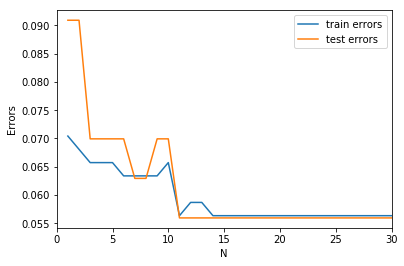

In [8]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict_lr(X_train, mods), y_train))
    test_errors.append(get_error(predict_lr(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right');